# Meta-Labelling Project for Algorithmic Trading

## Introduction
This project explores the potential of improving trading signal quality by applying a **meta-model** that filters and ranks signals generated by a baseline strategy.  

The baseline strategy was built on **Bollinger Bands**, combined with a short-term moving average and a persistence condition, providing a simple and transparent framework for experimentation.  
After generating signals, ground-truth labels were created using the **Triple-Barrier Labelling** method, which evaluates signal success from a forward-looking perspective.  

Subsequently, a feature set was engineered, and several machine learning algorithms were trained, including:  
- Logistic Regression (Baseline)  
- Support Vector Classifier (SVC)  
- Random Forest  
- Gradient Boosting  
- Stacking  

Finally, a **Backtesting phase** was conducted, comparing the performance of the baseline strategy against the meta-model enhanced strategy, with position sizing dynamically adjusted according to the model’s predicted probabilities.  

## Objectives
- Demonstrate how to improve **signal quality**, not merely signal quantity.  
- Showcase the added value of **Meta-Labelling** in quantitative trading research.  
- Provide a foundational experimental framework that can be extended to additional assets, different frequencies, and more advanced algorithms.  


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 'bold'

import seaborn as sns
import yfinance as yf
import vectorbt as vbt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import TimeSeriesSplit, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (classification_report, precision_score, recall_score, accuracy_score, f1_score, fbeta_score,
                            confusion_matrix, make_scorer, precision_recall_curve)


import sys
sys.path.append('../src')
from TripleBarrierLabel import TripleBarrierLabel

sys.path.append('../../Utilities/src')
from TimeSeriesEmbargoCV import TimeSeriesEmbargoCV

# 1. Download Data

In [2]:
amd = yf.download('AMD', 
                    start='2019-01-01',
                    end='2025-09-01')

C:\Users\USER\AppData\Local\Temp\ipykernel_16464\3414159427.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  amd = yf.download('AMD',
[*********************100%***********************]  1 of 1 completed


In [3]:
amd

Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2019-01-02,18.830000,19.000000,17.980000,18.010000,87148700
2019-01-03,17.049999,18.680000,16.940001,18.420000,117277600
2019-01-04,19.000000,19.070000,17.430000,17.549999,111878600
2019-01-07,20.570000,20.680000,19.000000,19.440001,107157000
2019-01-08,20.750000,21.200001,19.680000,21.190001,121271000
...,...,...,...,...,...
2025-08-25,163.360001,165.589996,161.720001,165.550003,36134700
2025-08-26,166.619995,169.770004,164.910004,168.649994,52138600


In [4]:
data = amd.drop(columns='Close')
prices = amd['Close'].squeeze()

In [5]:
prices

Date
2019-01-02     18.830000
2019-01-03     17.049999
2019-01-04     19.000000
2019-01-07     20.570000
2019-01-08     20.750000
                 ...    
2025-08-25    163.360001
2025-08-26    166.619995
2025-08-27    167.130005
2025-08-28    168.580002
2025-08-29    162.630005
Name: AMD, Length: 1675, dtype: float64

# 2. Bollinger-Based Basic Trading Strategy

- The strategy is built on **Bollinger Bands** combined with a **short-term moving average filter** and a **stability requirement** to generate reliable trading signals.  

---

### 2.1 Bollinger Bands
- A moving average of length $w$ (default $w=30$) is calculated:  
  $$
  MA_t = \frac{1}{w} \sum_{i=0}^{w-1} P_{t-i}
  $$
  where $P_t$ is the asset price at time $t$.  

- The rolling standard deviation of the same window is computed:  
  $$
  \sigma_t = \sqrt{\frac{1}{w} \sum_{i=0}^{w-1} (P_{t-i} - MA_t)^2}
  $$

- Upper and lower Bollinger Bands are constructed with an interval multiplier $k$:  
  $$
  B^{up}_t = MA_t + k \cdot \sigma_t
  $$
  $$
  B^{down}_t = MA_t - k \cdot \sigma_t
  $$

---

### 2.2 Short-Term Trend Filter
- A 14-period moving average is used to filter signals:  
  $$
  MA^{14}_t = \frac{1}{14} \sum_{i=0}^{13} P_{t-i}
  $$
- Long signals require the price to also be above $MA^{14}_t$, while short signals require it to be below $MA^{14}_t$.  
- This avoids counter-trend trades.

---

### 2.3 Signal Generation Rules
- **Long signal ($+1$):** When $P_t \geq B^{up}_t$ and $P_t \geq MA^{14}_t$.  
- **Short signal ($-1$):** When $P_t \leq B^{down}_t$ and $P_t \leq MA^{14}_t$.  
- Otherwise, the signal remains $0$.  

---

### 2.4 Stability Requirement
- To avoid noisy or transient signals, a **persistence condition** is imposed:  
  - A signal is only confirmed if it persists for at least $k=2$ consecutive periods.  
- Formally:  
  $$
  Signal_t =
  \begin{cases}
  +1 & \text{if a long condition holds for } k \text{ periods} \\
  -1 & \text{if a short condition holds for } k \text{ periods} \\
  0 & \text{otherwise}
  \end{cases}
  $$

---

### 2.5 Output
- The output is a **filtered and stable signal time series** aligned with the original index.  
- By combining **Bollinger Bands**, a **trend filter**, and a **stability condition**, the strategy reduces false positives and avoids reacting to short-lived price movements.  

In [6]:
def bollinger_signals(series, window=30, interval=1):
    """
    Generate trading signals using Bollinger Bands with a simple stability filter.
    Input:
        series  : pd.Series of prices
        window  : lookback window for SMA and STD
        interval: number of std deviations for bands
    Output:
        pd.Series of {-1, 0, 1} signals
    """
    import pandas as pd

    s = series.astype(float)

    # Bollinger bands
    ma = s.rolling(window).mean()
    std = s.rolling(window).std()
    b_up = ma + std * interval
    b_down = ma - std * interval

    # Simple trend filter: short-term MA
    ma14 = s.rolling(14).mean()

    # Base signals
    signals = pd.Series(0, index=s.index, dtype=int)
    signals[(s >= b_up) & (s >= ma14)] = 1
    signals[(s <= b_down) & (s <= ma14)] = -1

    # Stability: require signal to persist k periods
    k = 2
    stable_long = (signals == 1).rolling(k).sum() == k
    stable_short = (signals == -1).rolling(k).sum() == k
    signals[~(stable_long | stable_short)] = 0

    return signals[window-1:]

In [7]:
signals = bollinger_signals(prices)
signals.value_counts()

 0    909
 1    443
-1    294
Name: count, dtype: int64

# 3. Triple-Barrier Labelling

- After generating raw trading signals, we apply **Triple-Barrier Labelling** to assess whether a signal is successful or not within a fixed horizon.  
- This technique (introduced by López de Prado) places three barriers around each entry point:  
  - **Upper barrier:** defines the profit-taking threshold.  
  - **Lower barrier:** defines the stop-loss threshold.  
  - **Vertical barrier:** defines the maximum holding period (the horizon).  

- For each signal, we observe the forward price path up to the horizon:  
  - If the upper barrier is hit first → label $= +1$.  
  - If the lower barrier is hit first → label $= -1$.  
  - If neither is hit within the horizon → label $= 0$.  

- In this project:  
  - Horizon $=30$ steps forward.  
  - Volatility is estimated with a **rolling standard deviation** of window $=60$.  
  - Upper and lower multipliers are both $0.05$ (i.e., $\pm 5\%$ of volatility).  

In [8]:
tbl = TripleBarrierLabel(prices,
                        30)

In [9]:
tbl.fit_labels(0.02, 0.02, "moving_std", 60)

In [10]:
tbl_labels = tbl.labels

In [11]:
len(tbl_labels), len(signals)

(1646, 1646)

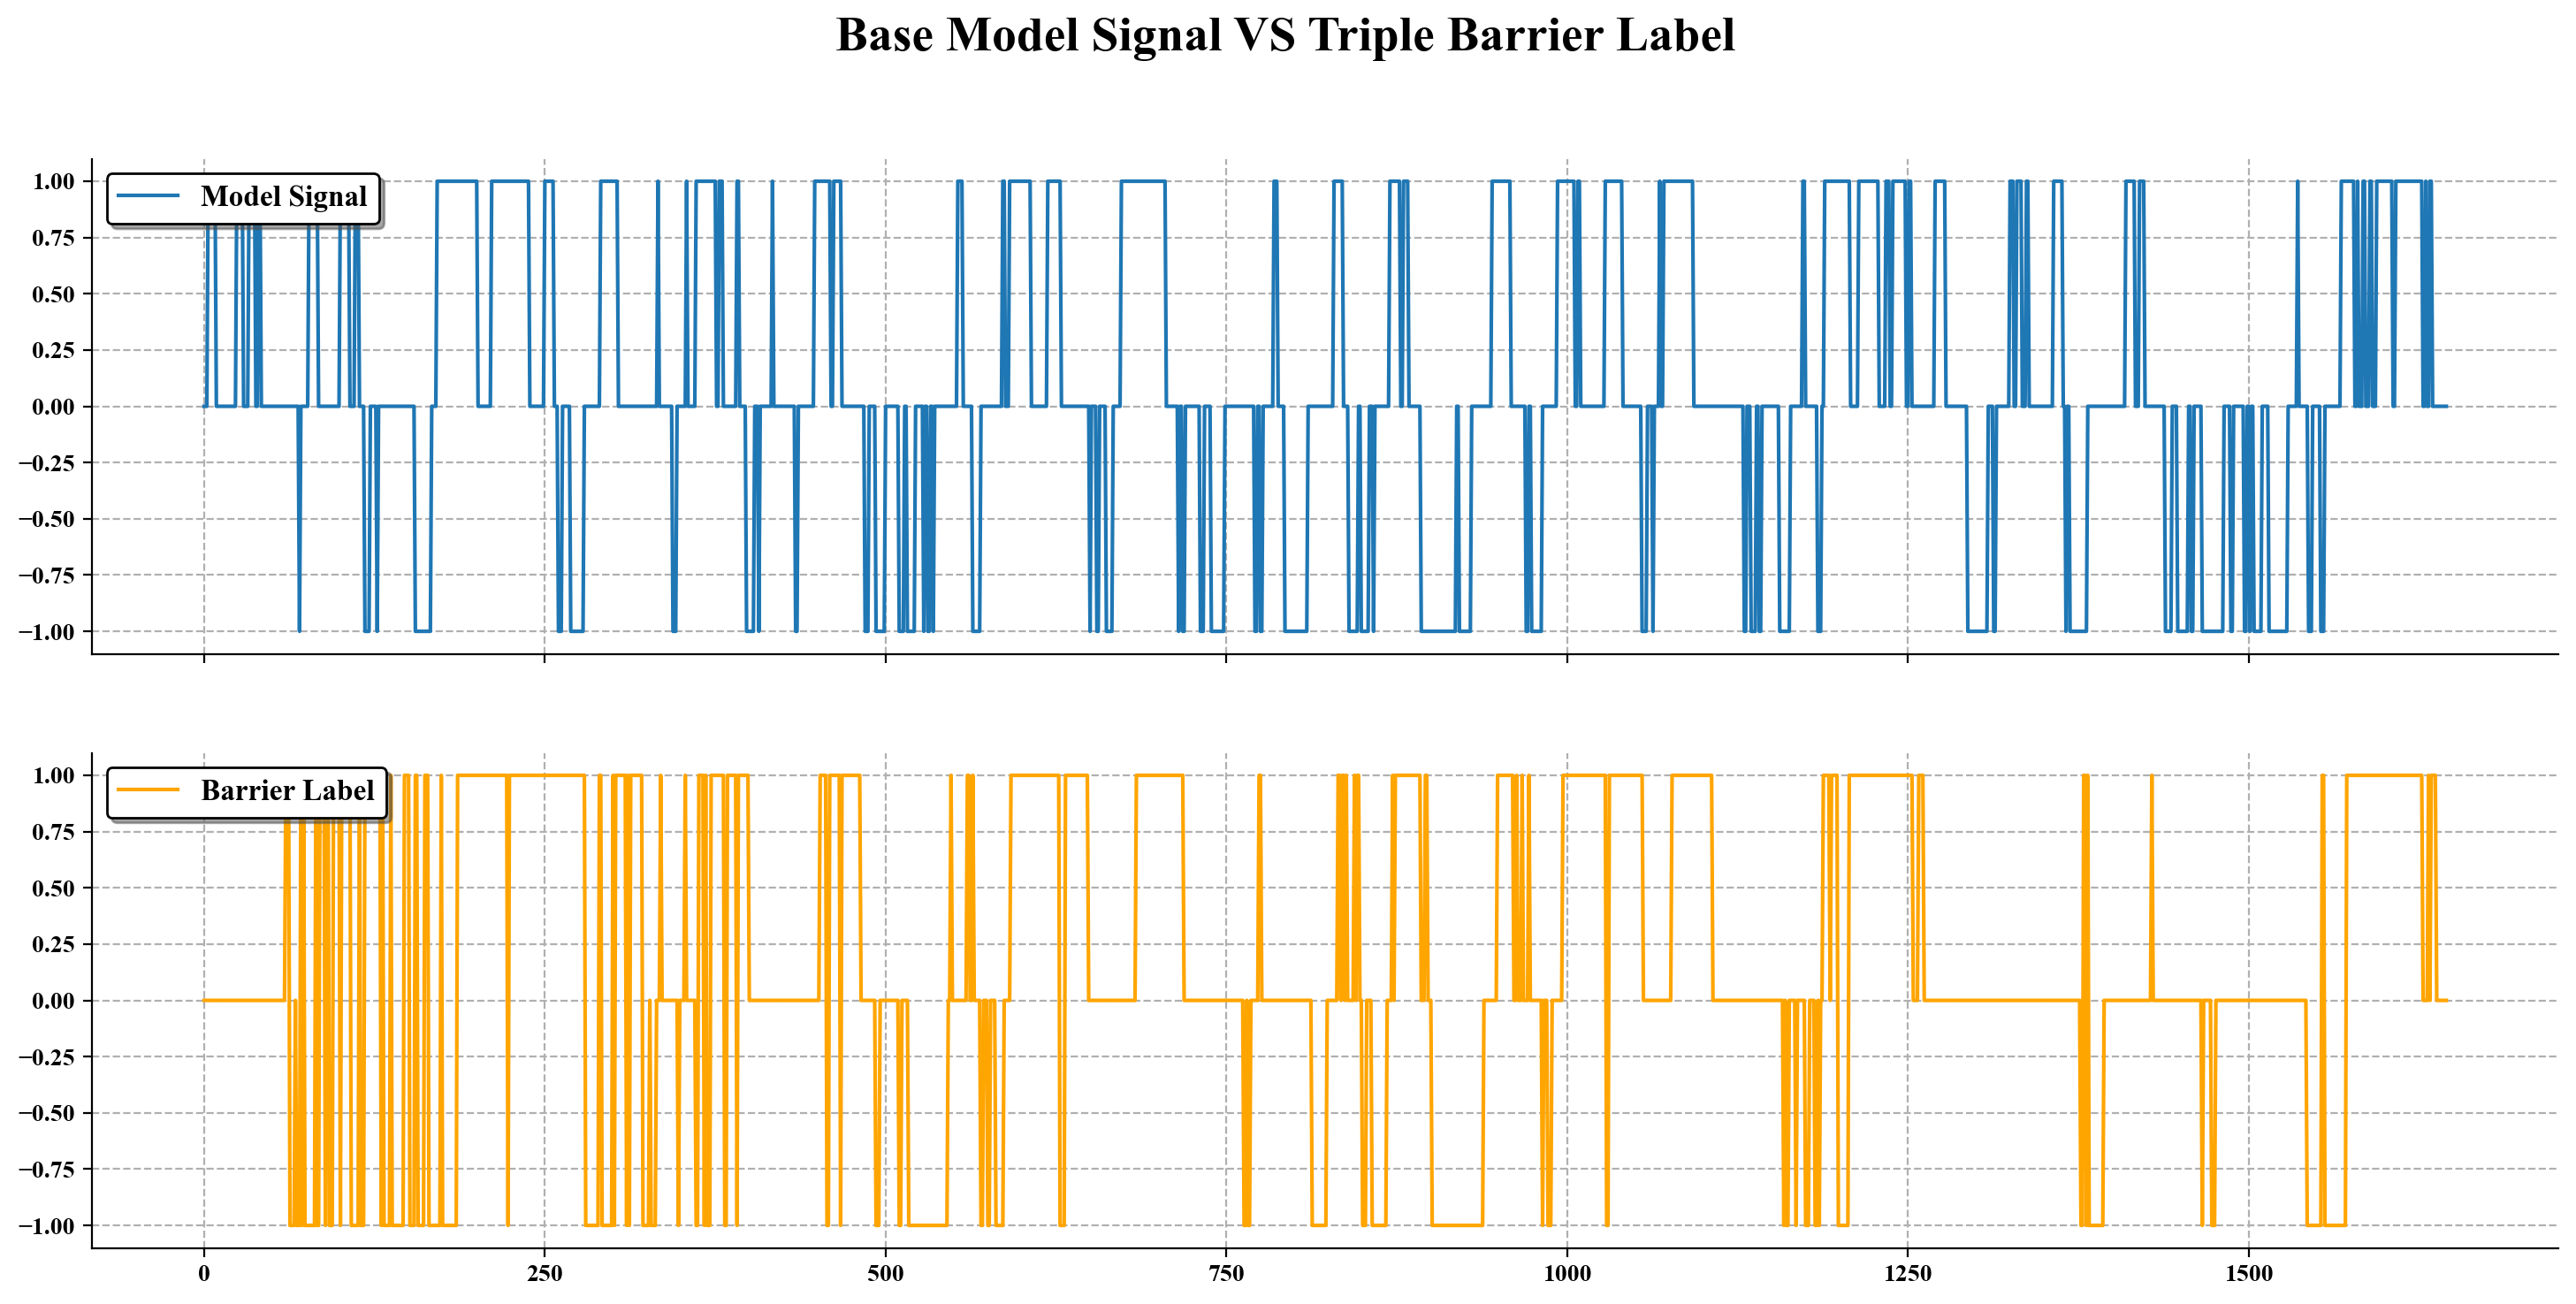

In [12]:
fig, ax = plt.subplots(2,1, figsize=(18,8), dpi=200, sharex=True)
ax[0].plot(signals.values, label='Model Signal')

ax[1].plot(tbl_labels, color='orange', label='Barrier Label')

for x in ax:
    x.grid(ls='--')
    x.legend(edgecolor='k', shadow=True,
            loc='upper left',
            prop={'size':12, 'weight':'bold'})

fig.suptitle('Base Model Signal VS Triple Barrier Label', weight='bold', size=20)

sns.despine()
plt.show()

# 4. Feature Engineering for Meta-Labelling

- After generating labels, we construct a **feature set** to train the meta-model.  
- The features are derived from price dynamics, statistical moments, and technical indicators.  

---

### 1. Bollinger Band Features
- Compute rolling mean $MA_t$ and standard deviation $\sigma_t$ with window $w$:  
  $$
  B^{up}_t = MA_t + k \cdot \sigma_t, \quad
  B^{down}_t = MA_t - k \cdot \sigma_t
  $$
- Store as `b_up` and `b_down`.

---

### 2. Rolling Statistics
- For windows of length $10$ and $30$:  
  - **Mean:** $\text{ma10}, \text{ma30}$  
  - **Std:** $\text{std10}, \text{std30}$  
  - **Skewness:** $\text{skew10}, \text{skew30}$  
  - **Kurtosis:** $\text{kurt10}, \text{kurt30}$  

---

### 3. Rolling Quantiles
- For both 10-day and 30-day windows:  
  - Lower quartile (25%) → `qXX_25`  
  - Upper quartile (75%) → `qXX_75`  
- Derived ratios and gaps:  
  - `qXX_ratio = qXX_75 / qXX_25`  
  - `qXX_gap = qXX_75 - qXX_25`

---

### 4. Price Dynamics
- **Rate of Change (10 days):**  
  $$
  ROC_{10}(t) = \frac{P_t - P_{t-10}}{P_{t-10}}
  $$  
- **Autoregressive coefficient (AR1):**  
  Estimated by:  
  $$
  \beta = \frac{\sum x_t y_t}{\sum x_t^2}
  $$
  where $x_t = P_{t-1}, y_t = P_t$ over a 10-day rolling window.

---

### 5. Time to Barrier
- From the triple-barrier labelling step:  
  - `tth` = number of steps until a barrier was hit.

---

### 6. Calendar Effects
- Encode weekdays as cyclic features:  
  $$
  \sin\_day = \sin\left(\frac{2\pi \cdot d}{7}\right), \quad
  \cos\_day = \cos\left(\frac{2\pi \cdot d}{7}\right)
  $$
  where $d \in \{0,1,\dots,6\}$ is the weekday.

---

### 7. Relative Gaps
- Price vs. moving averages:  
  - `price_ma30_gap = P_t - MA_{30,t}`  
  - `price_ma10_gap = P_t - MA_{10,t}`  
- Difference between moving averages:  
  - `ma_10_30_gap = MA_{30,t} - MA_{10,t}`  
- Difference between volatilities:  
  - `std_10_30_gap = std_{30,t} - std_{10,t}`  

---

### 8. Technical Indicators
- **RSI (14-period):** Relative Strength Index, measuring momentum by comparing recent gains and losses.  
- **MACD (12-26-9):** Moving Average Convergence Divergence, highlighting trend strength and turning points.  
- **ATR (14-period):** Average True Range, capturing market volatility based on high, low, and close prices.  
- **OBV:** On-Balance Volume, cumulative indicator that relates price movement to trading volume.  
- **VWAP:** Volume-Weighted Average Price, calculated as the cumulative dollar value traded divided by cumulative volume, reflecting the average price at which the asset has traded.  
---

- This feature set combines **statistical**, **technical**, and **temporal** information, forming the input for the meta-labelling classifier.


In [13]:
def bollinger_features(series, window=30, interval=1):
    ma = series.rolling(window).mean()
    std = series.rolling(window).std()

    b_up = (ma + std * interval).values.flatten()
    b_down = (ma - std * interval).values.flatten()

    return pd.DataFrame({
        'b_up': b_up,
        'b_down': b_down
    }, index=series.index)

In [14]:
df = bollinger_features(prices)[29:]

In [15]:
df['ma10'] = prices.rolling(10).mean()
df['std10'] = prices.rolling(10).std()
df['skew10'] = prices.rolling(10).skew()
df['kurs10'] = prices.rolling(10).kurt()

df['ma30'] = prices.rolling(30).mean()
df['std30'] = prices.rolling(30).std()
df['skew30'] = prices.rolling(30).skew()
df['kurt30'] = prices.rolling(30).kurt()

df['q10_25'] = prices.rolling(10).quantile(0.25)
df['q10_75'] = prices.rolling(10).quantile(0.75)

df['q30_25'] = prices.rolling(30).quantile(0.25)
df['q30_75'] = prices.rolling(30).quantile(0.75)

df['roc10'] = prices.pct_change(10)


def make_autoreg_coef(data):
    arr = np.asarray(data, float)
    x = arr[:-1]
    y = arr[1:]
    beta = (x @ y) / (x @ x)
    return beta
df['AR1'] = prices.rolling(10).apply(make_autoreg_coef, raw=True)

df['tth'] = tbl.time_to_hit

weekdays = df.index.weekday
df['sin_day'] = np.sin(2 * np.pi * weekdays / 7)
df['cos_day'] = np.cos(2 * np.pi * weekdays / 7)

df['q30_ratio'] = df['q30_75'] / df['q30_25']
df['q30_gap'] = df['q30_75'] - df['q30_25']

df['q10_ratio'] = df['q10_75'] / df['q10_25']
df['q10_gap'] = df['q10_75'] - df['q10_25']

df['price_ma30_gap'] = prices - df['ma30']
df['price_ma10_gap'] = prices - df['ma10']
df['ma_10_30_gap'] = df['ma30'] - df['ma10']
df['std_10_30_gap'] = df['std30'] - df['std10']

df['rsi'] = vbt.RSI.run(prices, window=14).rsi
df['macd'] = vbt.MACD.run(prices, fast_window=12, slow_window=26, signal_window=9).macd
df['atr'] = vbt.ATR.run(high=data['High'], low=data['Low'], close=prices).atr
df['obv'] = vbt.OBV.run(prices, data['Volume']).obv
df['vwap'] = (amd['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

In [16]:
df = df.dropna()

# Target Construction for Meta-Labelling

- The **goal of meta-labelling** is to evaluate the reliability of primary trading signals.  
- We compare the raw **trading signal** with the **triple-barrier label**.  

---

### Definition
- Let $S_t$ = trading signal at time $t$ (from the Bollinger strategy).  
- Let $L_t$ = outcome label at time $t$ (from triple-barrier labelling).  
- Define the target variable:  
  $$
  Y_t =
  \begin{cases}
  1 & \text{if } L_t = S_t \quad \text{(signal was correct)} \\
  0 & \text{otherwise (signal failed or no match)}
  \end{cases}
  $$

In [17]:
target = (tbl_labels==signals).astype(int)

In [18]:
target.value_counts()

0    833
1    813
Name: count, dtype: int64

# 5. Data Preparation for Model Training

## 5.1 Train–Test Split
- Time-series data must be split **chronologically** to preserve temporal order.  
- Unlike random splits, this method ensures that the model trains on past data and tests on future data.  
- Training size is computed as $(1 - \text{test\_size}) \times N$, where $N$ is the number of samples.  
- The result is:  
  - $X_{train}, Y_{train}$ --> historical training set  
  - $X_{test}, Y_{test}$ --> forward-looking test set

In [19]:
def split_timeseries(x, y, test_size=0.25):
    train_size = int((1-test_size)*len(x))
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return x_train, x_test, y_train, y_test

In [20]:
x_train, x_test, y_train, y_test = split_timeseries(df, target)

### 5.2 Normality Check
- Feature distributions are tested using the **Shapiro–Wilk test**.  
- Null hypothesis: *the data is normally distributed*.  
- Decision rule:  
  - If $p \geq 0.05$ --> cannot reject normality (feature may be normal).  
  - If $p < 0.05$ --> reject normality (feature is not normally distributed).  
- In practice, most financial features **fail the normality test**, which motivates robust scaling methods later on.

In [21]:
def check_normality(df):
    for col in df.columns:
        p = shapiro(df[col])[1]
        if p >= 0.05:
            print(f'✅ {col} is Normal')
        else:
            print(f'❌ {col} is not Normal')

In [22]:
check_normality(df)

❌ b_up is not Normal
❌ b_down is not Normal
❌ ma10 is not Normal
❌ std10 is not Normal
✅ skew10 is Normal
❌ kurs10 is not Normal
❌ ma30 is not Normal
❌ std30 is not Normal
❌ skew30 is not Normal
❌ kurt30 is not Normal
❌ q10_25 is not Normal
❌ q10_75 is not Normal
❌ q30_25 is not Normal
❌ q30_75 is not Normal
❌ roc10 is not Normal
❌ AR1 is not Normal
❌ tth is not Normal
❌ sin_day is not Normal
❌ cos_day is not Normal
❌ q30_ratio is not Normal
❌ q30_gap is not Normal
❌ q10_ratio is not Normal
❌ q10_gap is not Normal
❌ price_ma30_gap is not Normal
❌ price_ma10_gap is not Normal
❌ ma_10_30_gap is not Normal
❌ std_10_30_gap is not Normal
❌ rsi is not Normal
❌ macd is not Normal
❌ atr is not Normal
❌ obv is not Normal
❌ vwap is not Normal


In [23]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [24]:
print(f'x_train_scaled shape: {x_train_scaled.shape}, y_train shape:{y_train.shape}')
print(f'x_test_scaled shape: {x_test_scaled.shape}, y_test shape:{y_test.shape}')

x_train_scaled shape: (1234, 32), y_train shape:(1234,)
x_test_scaled shape: (412, 32), y_test shape:(412,)


# 6. Evaluation Utilities for Classifiers

- To streamline the assessment of meta-models, several helper functions are implemented.  
- These functions provide **classification metrics**, **confusion matrix visualization**, **learning curves**, and **F-beta threshold analysis**.

---

## 6.1 Evaluation Metrics
- Computes standard performance scores:  
  - **Precision**: $ \frac{TP}{TP + FP} $  
  - **Recall**: $ \frac{TP}{TP + FN} $  
  - **Accuracy**: $ \frac{TP + TN}{TP + TN + FP + FN} $  
  - **F1 Score**: harmonic mean of precision and recall.  
  - **F$_{\beta}$ Score** (here with $\beta=0.5$):  
    $$
    F_{\beta} = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{\beta^2 \cdot \text{Precision} + \text{Recall}}
    $$

---

## 6.2 Confusion Matrix
- Visual tool that displays:  
  - Rows = actual classes  
  - Columns = predicted classes  
- Allows quick inspection of **false positives**, **false negatives**, and correct classifications.  
- Implemented with a **heatmap** for clarity.

---

## 6.3 Learning Curves
- Plots training and validation performance as a function of training set size.  
- Useful for diagnosing:  
  - **Underfitting** (low scores on both training and test).  
  - **Overfitting** (large gap between training and test).  
- Confidence intervals are displayed using ±1 standard deviation.  
- The evaluation metric is **F$_{0.75}$**, reflecting a preference toward recall while penalizing false negatives.

---

## 6.4 F-beta Threshold Curve
- Evaluates the classifier’s performance across different probability thresholds.  
- For each threshold $t$:  
  - Predictions are set to $\hat{y}=1$ if $p \geq t$, else $\hat{y}=0$.  
  - The corresponding $F_{\beta}$ score is computed.  
- The best threshold maximizes $F_{\beta}$.  
- The PR (Precision–Recall) curve is plotted with a marker at the optimal threshold.

---

- Together, these tools provide a **comprehensive evaluation pipeline** for comparing and fine-tuning classifiers in the meta-labelling framework.


In [25]:
def evaluate_classifier(y_true, y_pred):
    results = {}
    results['Precision'] = precision_score(y_true, y_pred)
    results['Recall'] = recall_score(y_true, y_pred)
    results['Accuracy'] = accuracy_score(y_true, y_pred)
    results['f1'] = f1_score(y_true, y_pred)
    results['f_beta(0.75)'] = fbeta_score(y_true, y_pred, beta=0.75)
    return results

In [26]:
def plot_cm(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4,3), dpi=200)
    sns.heatmap(cm,
               annot=True,
               fmt='d',
               cbar=False)
    plt.ylabel('Real Value', weight='bold')
    plt.xlabel('Predicted Value', weight='bold')
    plt.title(f'{model_name} - Confusion Matrix',
             size=16, weight='bold')
    plt.show()

In [27]:
def make_learning_curves (estimator, x, y, plot=True, title=None):
    scorer = make_scorer(fbeta_score, beta=0.75)
    train_size, train_scores, test_scores = learning_curve(estimator,
                                                           x, y,
                                                           scoring = scorer,
                                                           n_jobs=-1)
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)

    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    if plot:
        train_ub = train_mean + train_std
        train_lb = train_mean - train_std
        test_ub = test_mean + test_std
        test_lb = test_mean - test_std
        
        plt.figure(figsize=(18,5), dpi=200)
        plt.plot(train_size, train_mean, label='Train Average F')
        plt.plot(train_size, test_mean, label='Test Average F')
        plt.fill_between(train_size, train_lb, train_ub, alpha=.2)
        plt.fill_between(train_size, test_lb, test_ub, alpha=.2)
        plt.xlabel('Train Size', weight='bold')
        plt.ylabel('F Score', weight='bold')
        plt.grid(ls='--')
        plt.legend(edgecolor='k')
        if title:
            plt.title(title, size=20, weight='bold')
        sns.despine()
        plt.show()
        plt.close()
        
        return None
        
    return train_mean, train_std, test_mean, test_std

In [28]:
def make_fbeta_curve(y_true, y_prob, beta=0.5, title=None):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    fbeta_scores = [
        fbeta_score(y_true, (y_prob >= t).astype(int), beta=beta)
        for t in thresholds]
    
    best_index = np.argmax(fbeta_scores)
    best_threshold = thresholds[best_index]

    print(f'Best Fb Threshold: {best_threshold}')

    plt.figure(figsize=(18,5), dpi=200)
    plt.plot(recall, precision, label='PR Curve')
    plt.scatter(recall[best_index], precision[best_index],
                label=f'Best F{beta}',
                color='r', zorder=2)

    plt.xlabel('Recall', size=14, weight='bold')
    plt.ylabel('Precision', size=14, weight='bold')

    if title:
        plt.title(title, size=20, weight='bold')
    plt.grid(ls='--')
    plt.legend(edgecolor='k',
              prop={'size':14})
    sns.despine()
    plt.show()
    return best_threshold

# 7. Model Training

## 7.1 Logistic Regression as Baseline
- The first classifier used as a **baseline** is **Logistic Regression** with isotonic probability calibration.  
- Setup includes:  
  - **Cross-validation:** Custom **TimeSeriesEmbargoCV**, which adds an *embargo period* (a gap) between train and test folds to avoid data leakage and lookahead bias.  
  - **Max iterations:** 1000 for stable convergence.  
  - **Calibration:** `CalibratedClassifierCV` with isotonic method, ensuring well-calibrated probability outputs.  
  - **Parallelization:** `n_jobs = -1` to use all available cores.  
> ❓ For details on **TimeSeriesEmbargoCV**, see the project’s *Utilities* module.

---

### Training Procedure
- **Learning Curve Analysis**  
  - Training and validation F$_{0.5}$ scores are plotted to diagnose bias/variance trade-offs.  

- **Model Fitting**  
  - The model is trained on the scaled training set $(X_{train}, Y_{train})$.  

- **Predictions**  
  - Training predictions $\hat{Y}_{train}$ and test predictions $\hat{Y}_{test}$ are obtained.  
  - Test probabilities $\hat{p}_{test}$ are extracted for further threshold optimization.  

---

### Threshold Optimization
- Instead of using the default threshold $p=0.5$, an **optimal threshold** is selected to maximize the F$_{0.5}$ score.  
- Example:  
  - Optimal threshold $\approx 0.71$ gave better balance between **precision** and **recall**.  
  - Optimized predictions:  
    $$
    \hat{Y}_{test} =
    \begin{cases}
    1 & \text{if } \hat{p}_{test} \geq 0.71 \\
    0 & \text{otherwise}
    \end{cases}
    $$

---

### Evaluation
- **Training Set:** Evaluate metrics (precision, recall, accuracy, F1, F$_{0.5}$).  
- **Test Set:** Evaluate metrics using optimized threshold predictions.  
- **Confusion Matrix:** Plotted to visualize distribution of correct/incorrect classifications.  
- **Precision–Recall Curve:** Plotted with marker at the best threshold.

---

- Logistic Regression provides a **robust, interpretable baseline** for the meta-labelling task.  
- This serves as a reference point before testing more complex models.

In [29]:
logreg = CalibratedClassifierCV(estimator=LogisticRegressionCV(cv=TimeSeriesEmbargoCV(5, embargo_size=5),                    
                                 max_iter=100),
                                method='isotonic',
                               n_jobs=-1)

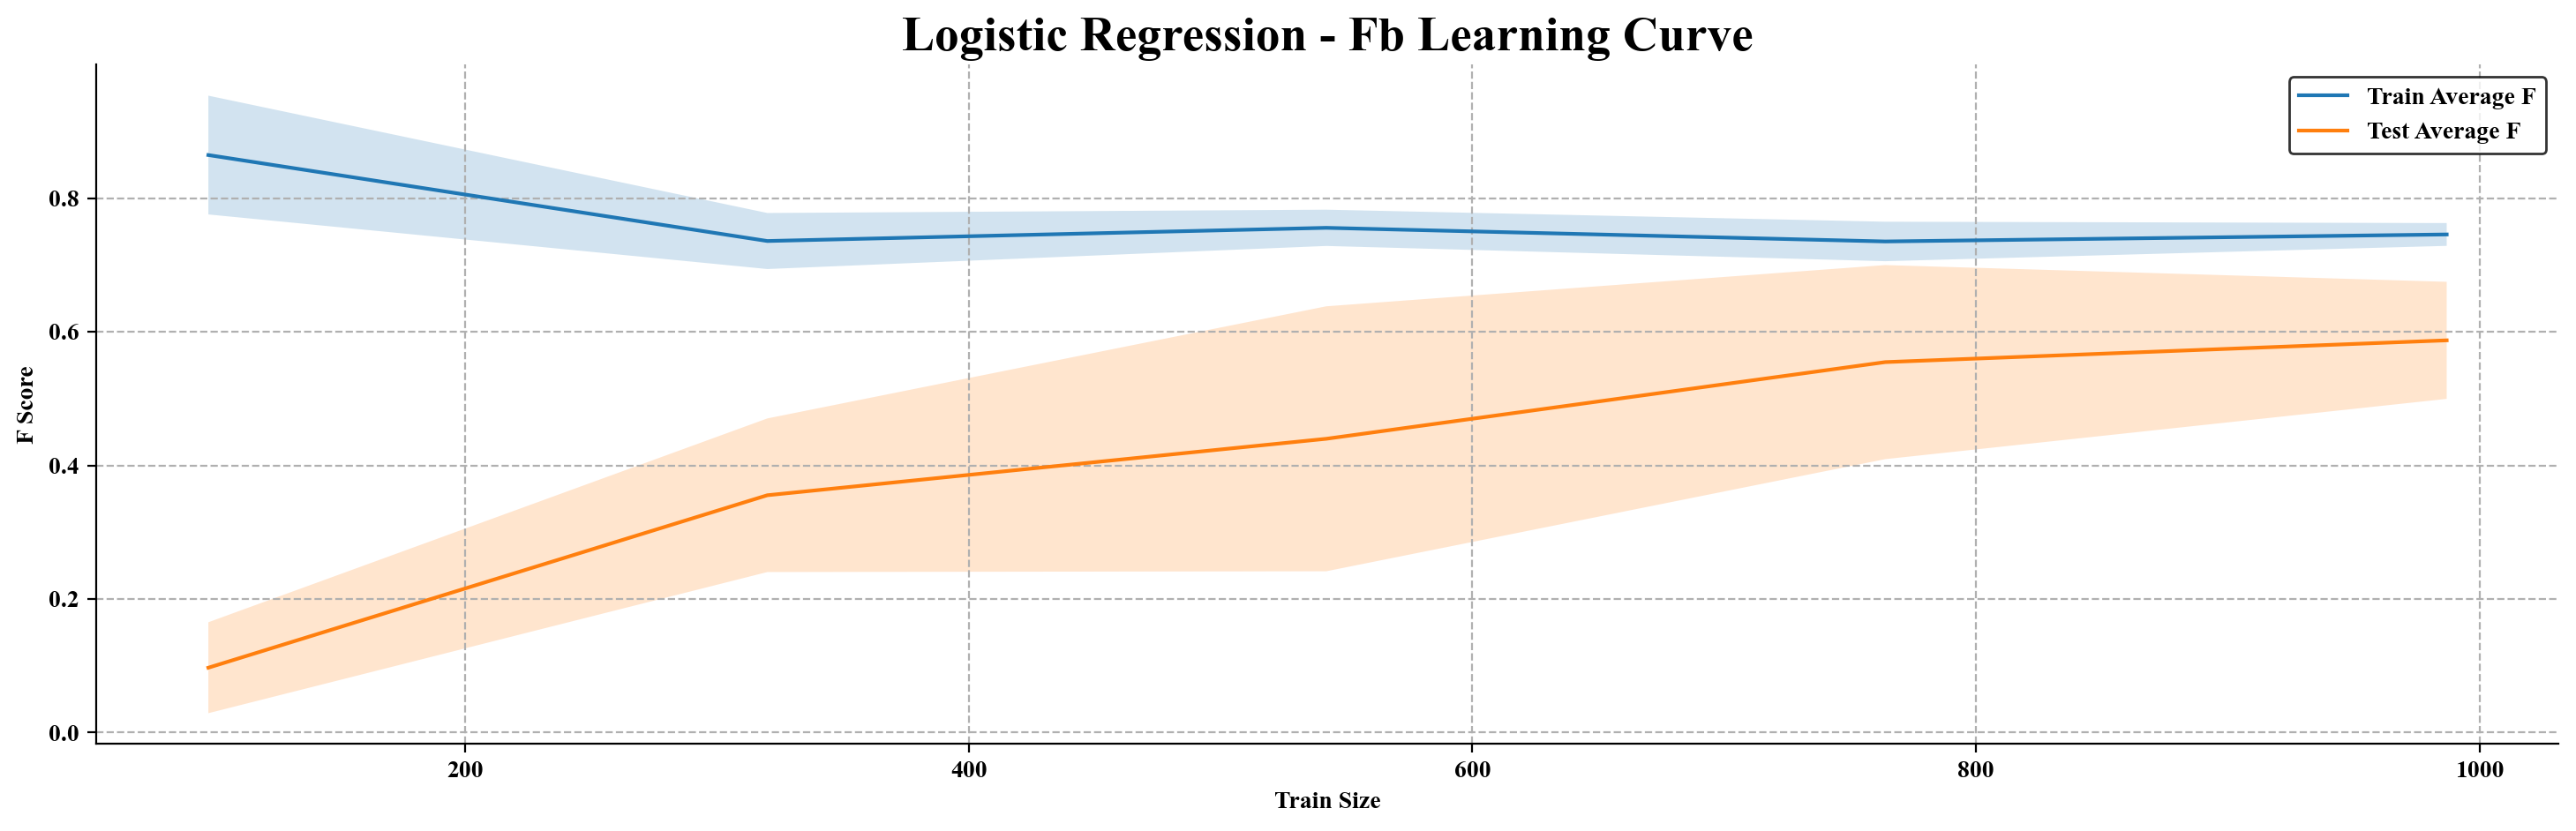

In [30]:
make_learning_curves(logreg, x_train_scaled, y_train, title='Logistic Regression - Fb Learning Curve')

In [31]:
logreg.fit(x_train_scaled, y_train)

CalibratedClassifierCV(estimator=LogisticRegressionCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5)),
                       method='isotonic', n_jobs=-1)

In [32]:
logreg_train_pred = logreg.predict(x_train_scaled)
logreg_test_pred = logreg.predict(x_test_scaled)

logreg_train_prob = logreg.predict_proba(x_train_scaled)[:, 1]
logreg_test_prob = logreg.predict_proba(x_test_scaled)[:, 1]

Best Fb Threshold: 0.5399966085537773


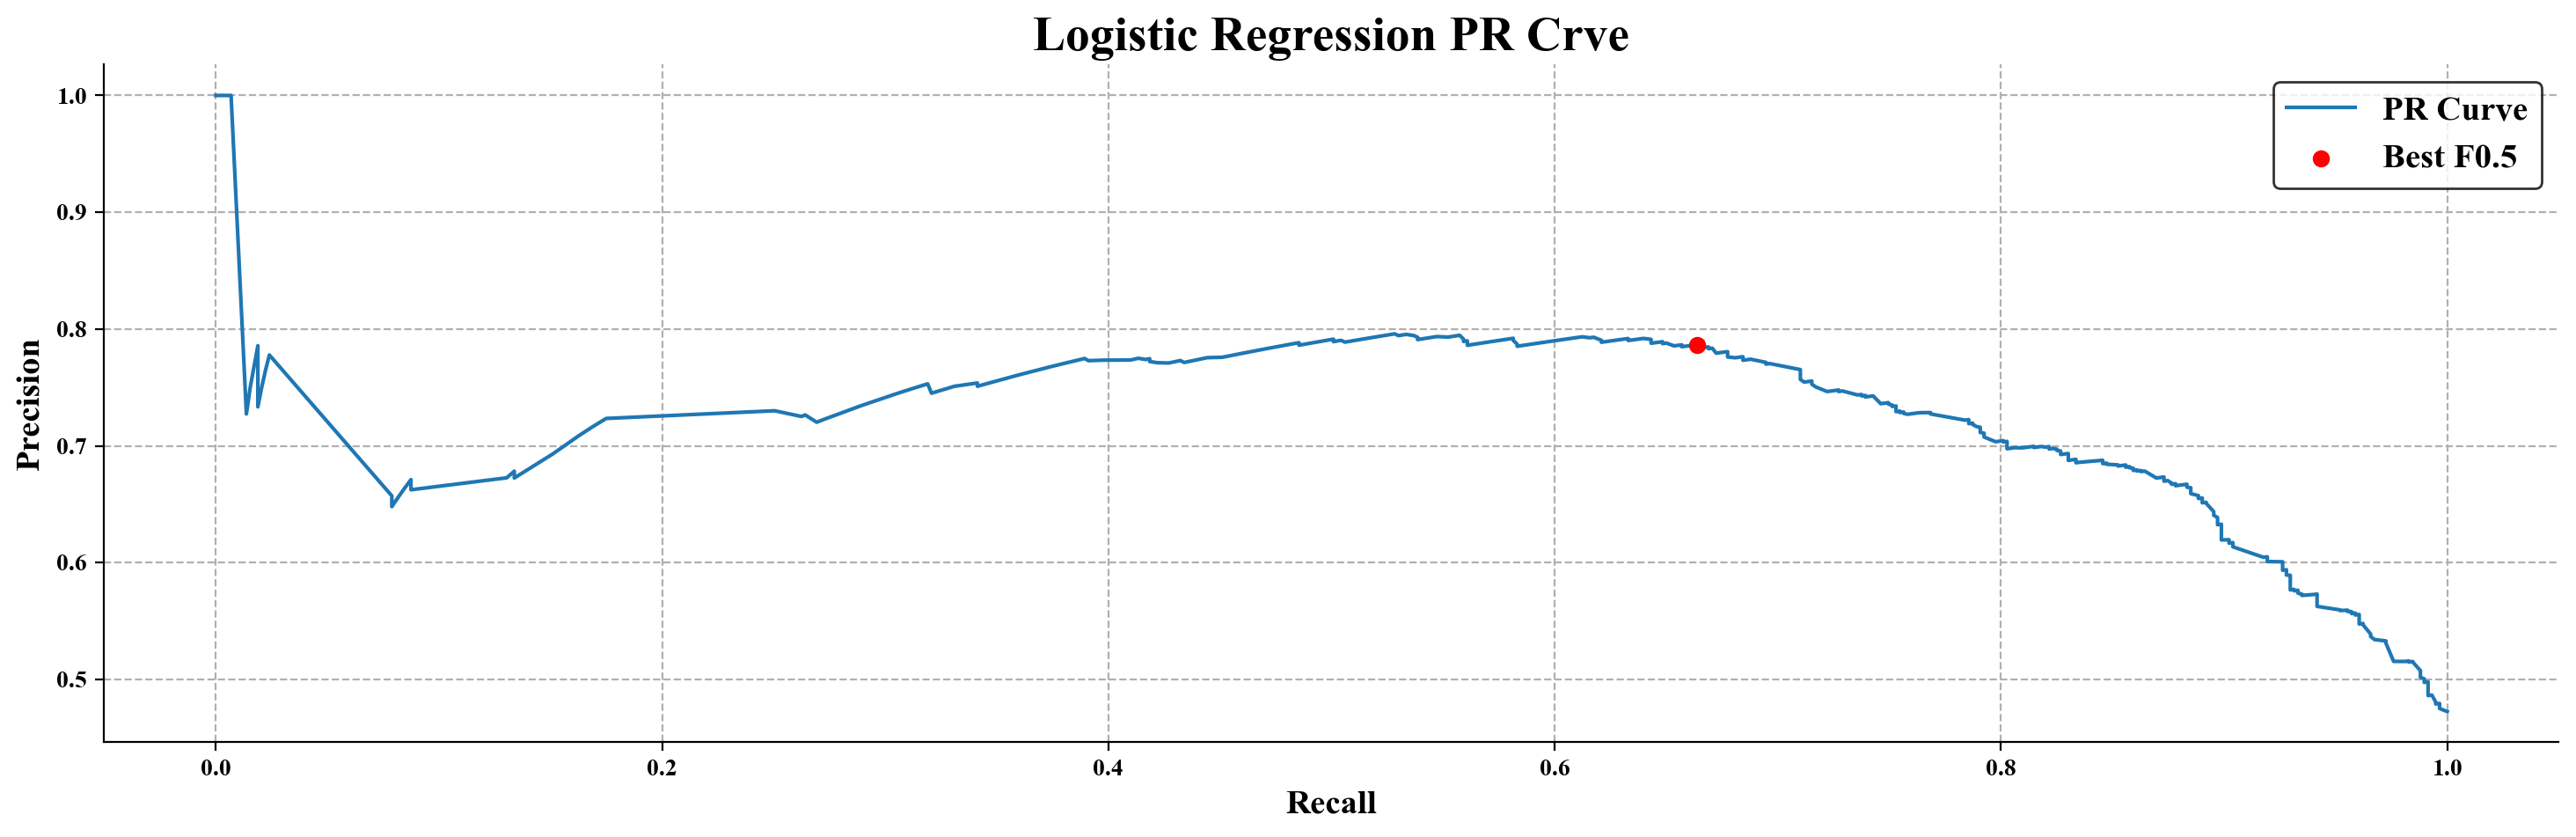

In [33]:
logreg_best_threshold = make_fbeta_curve(y_train, logreg_train_prob, 0.5, title='Logistic Regression PR Crve')

In [34]:
logreg_optimized_train_pred = (logreg_train_prob >= logreg_best_threshold).astype(int)
logreg_optimized_test_pred = (logreg_test_prob >= logreg_best_threshold).astype(int)

In [35]:
evaluate_classifier(y_train, logreg_optimized_train_pred)

{'Precision': 0.7865853658536586,
 'Recall': 0.6638078902229846,
 'Accuracy': 0.7560777957860616,
 'f1': 0.72,
 'f_beta(0.75)': 0.7374799908529613}

In [36]:
evaluate_classifier(y_test, logreg_optimized_test_pred)

{'Precision': 0.680672268907563,
 'Recall': 0.7043478260869566,
 'Accuracy': 0.6504854368932039,
 'f1': 0.6923076923076923,
 'f_beta(0.75)': 0.6890098673018034}

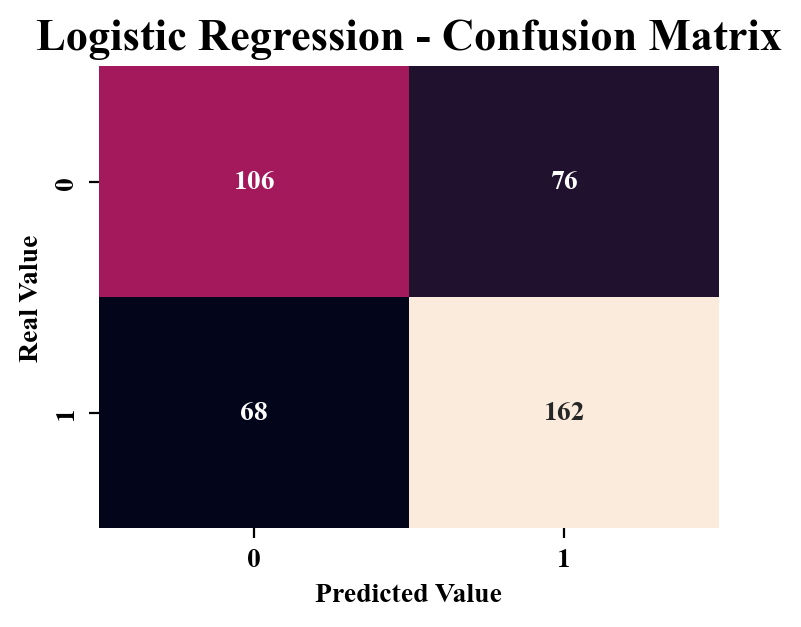

In [37]:
plot_cm(y_test, logreg_optimized_test_pred, 'Logistic Regression')

## 7.2 Support Vector Classifier (SVC)
- After Logistic Regression, a **Support Vector Classifier (SVC)** is trained as the next model in the meta-labelling pipeline.  
- Setup includes:  
  - **Base estimator:** SVC with `probability=True` to enable calibrated probability outputs.  
  - **Cross-validation:** `TimeSeriesEmbargoCV(cv=5, embargo_size=5)` ensures temporal splits with an embargo gap to reduce leakage.  
  - **Calibration:** Isotonic method applied via `CalibratedClassifierCV` for well-calibrated probabilities.  
  - **Random seed:** 42 for reproducibility.  
  - **Parallelization:** `n_jobs = -1` to use all available cores.  

- The **training, threshold optimization, and evaluation procedure** follows the same methodology as in the Logistic Regression baseline.  


In [38]:
svc = CalibratedClassifierCV(estimator=SVC(random_state=42,
                                         probability=True),
                             cv=TimeSeriesEmbargoCV(cv=5, embargo_size=5),
                             method='isotonic',
                             n_jobs=-1)

In [39]:
svc.fit(x_train_scaled, y_train)

CalibratedClassifierCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5),
                       estimator=SVC(probability=True, random_state=42),
                       method='isotonic', n_jobs=-1)

In [40]:
svc_train_pred = svc.predict(x_train_scaled)
svc_test_pred = svc.predict(x_test_scaled)

svc_train_prob = svc.predict_proba(x_train_scaled)[:, 1]
svc_test_prob = svc.predict_proba(x_test_scaled)[:, 1]

Best Fb Threshold: 0.5341940663712011


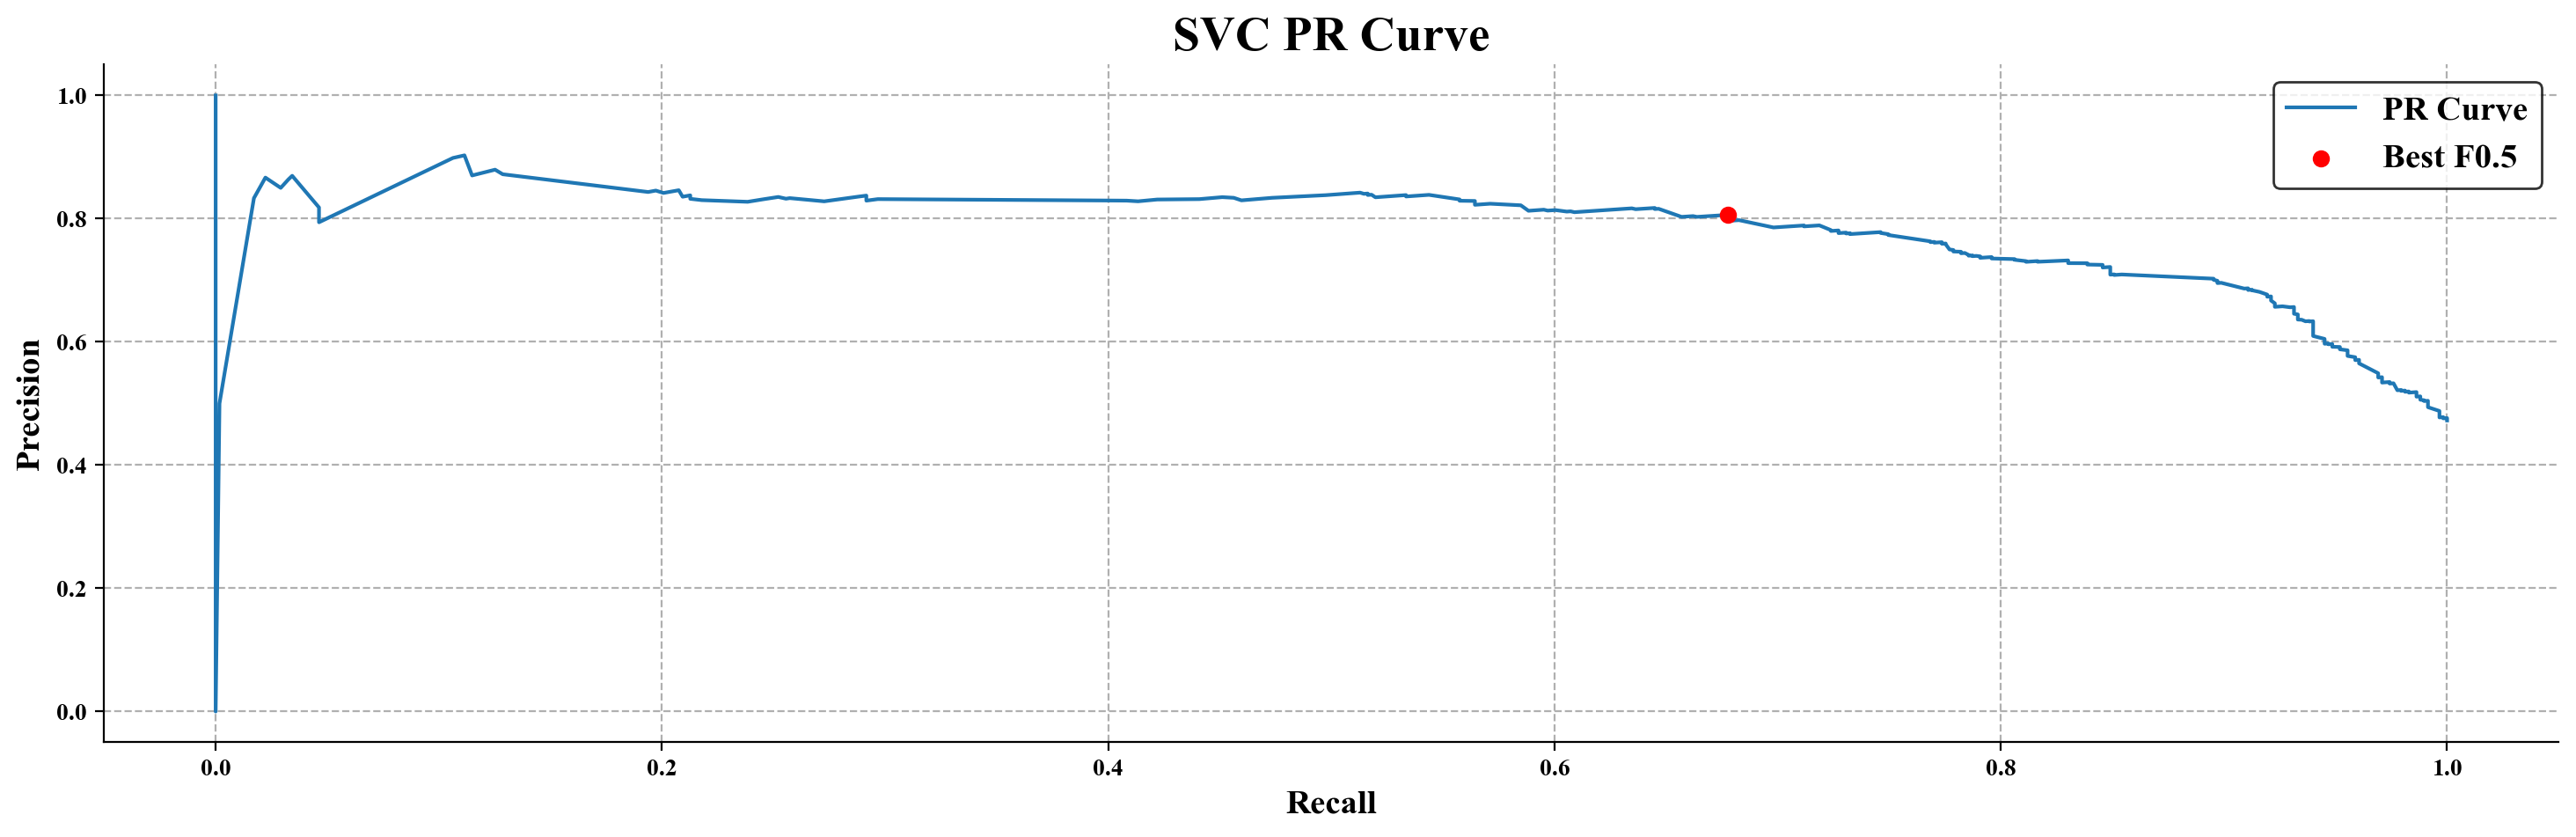

In [41]:
best_svc_threshold = make_fbeta_curve(y_train, svc_train_prob, 0.5, 'SVC PR Curve')

In [42]:
svc_optimized_train_pred = (svc_train_prob >= best_svc_threshold).astype(int)
svc_optimized_test_pred = (svc_test_prob >= best_svc_threshold).astype(int)

In [43]:
evaluate_classifier(y_train, svc_optimized_train_pred)

{'Precision': 0.8061224489795918,
 'Recall': 0.6775300171526587,
 'Accuracy': 0.7706645056726094,
 'f1': 0.7362534948741846,
 'f_beta(0.75)': 0.7545655994498357}

In [44]:
evaluate_classifier(y_test, svc_optimized_test_pred)

{'Precision': 0.7091633466135459,
 'Recall': 0.7739130434782608,
 'Accuracy': 0.6966019417475728,
 'f1': 0.7401247401247402,
 'f_beta(0.75)': 0.7311863292803155}

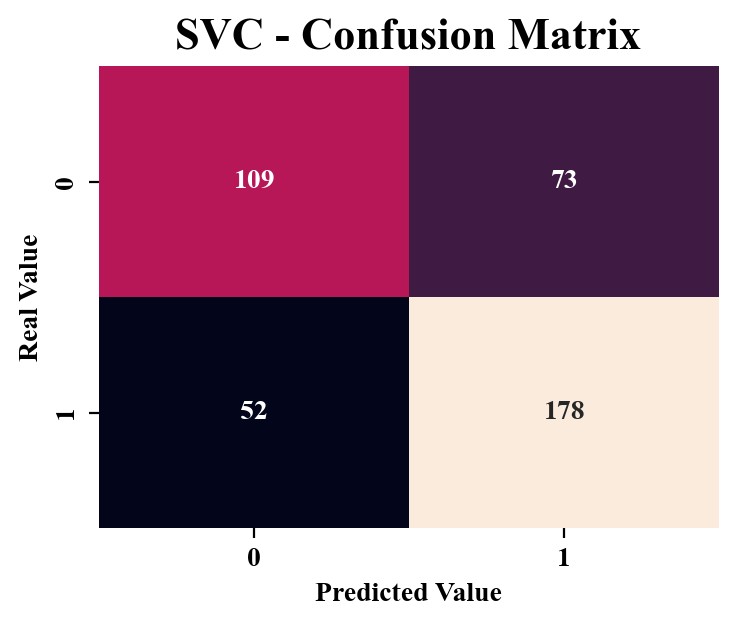

In [45]:
plot_cm(y_test, svc_optimized_test_pred, 'SVC')

## 7.3 Random Forest Classifier
- As a third model, a **Random Forest Classifier** is trained in the meta-labelling pipeline.  
- Setup includes:  
  - **Base estimator:** RandomForestClassifier with `n_estimators=200` and `random_state=42` for reproducibility.  
  - **Cross-validation:** `TimeSeriesEmbargoCV(cv=5, embargo_size=5)` to prevent leakage between folds.  
  - **Calibration:** Isotonic method applied via `CalibratedClassifierCV` for probability calibration.  
  - **Parallelization:** `n_jobs = -1` to use all available cores.  

- The **training process, threshold optimization, and evaluation** steps are identical to those used in Logistic Regression and SVC.  

- Unlike the previous models, **learning curves were not estimated** for Random Forest, since ensemble methods are generally **less sensitive to sample size growth** and tend to stabilize quickly due to averaging across many trees.  
- For documentation purposes, the baseline performance metrics were considered sufficient without the additional learning curve analysis.  

In [46]:
forest = CalibratedClassifierCV(estimator=RandomForestClassifier(random_state=42,
                                                                n_estimators=200),
                                cv=TimeSeriesEmbargoCV(cv=5, embargo_size=5),
                                method='isotonic',
                                n_jobs=-1
                               )

In [47]:
forest.fit(x_train_scaled, y_train)

CalibratedClassifierCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5),
                       estimator=RandomForestClassifier(n_estimators=200,
                                                        random_state=42),
                       method='isotonic', n_jobs=-1)

In [48]:
forest_train_pred = forest.predict(x_train_scaled)
forest_test_pred = forest.predict(x_test_scaled)

forest_train_prob = forest.predict_proba(x_train_scaled)[:, 1]
forest_test_prob = forest.predict_proba(x_test_scaled)[:, 1]

Best Fb Threshold: 0.49994610681442464


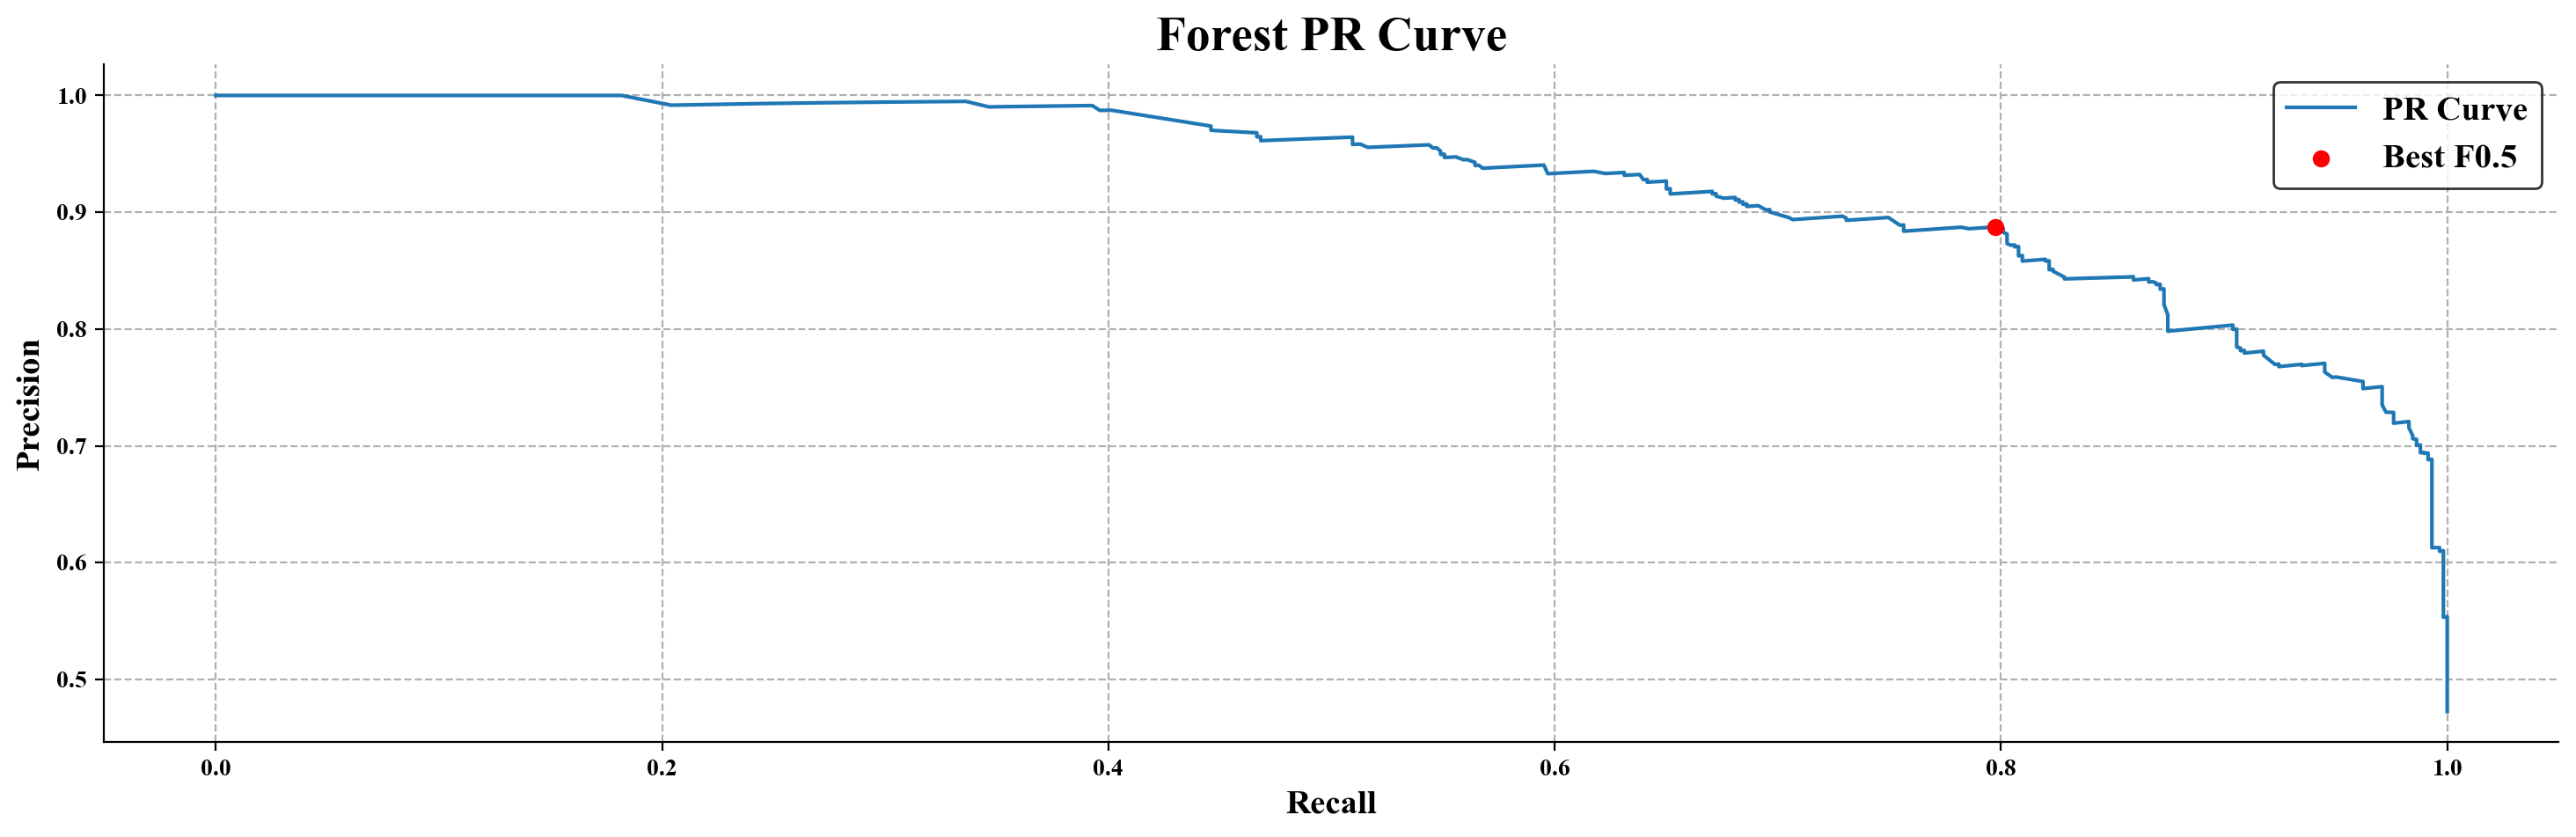

In [49]:
forest_best_threshold = make_fbeta_curve(y_train, forest_train_prob, 0.5, 'Forest PR Curve')

In [50]:
forest_optimized_train_pred = (forest_train_prob >= forest_best_threshold).astype(int)
forest_optimized_test_pred = (forest_test_prob >= forest_best_threshold).astype(int)

In [51]:
evaluate_classifier(y_train, forest_optimized_train_pred)

{'Precision': 0.8874045801526718,
 'Recall': 0.7975986277873071,
 'Accuracy': 0.8565640194489466,
 'f1': 0.8401084010840109,
 'f_beta(0.75)': 0.8528354486097866}

In [52]:
evaluate_classifier(y_test, forest_optimized_test_pred)

{'Precision': 0.700374531835206,
 'Recall': 0.8130434782608695,
 'Accuracy': 0.7014563106796117,
 'f1': 0.7525150905432596,
 'f_beta(0.75)': 0.7371491643014821}

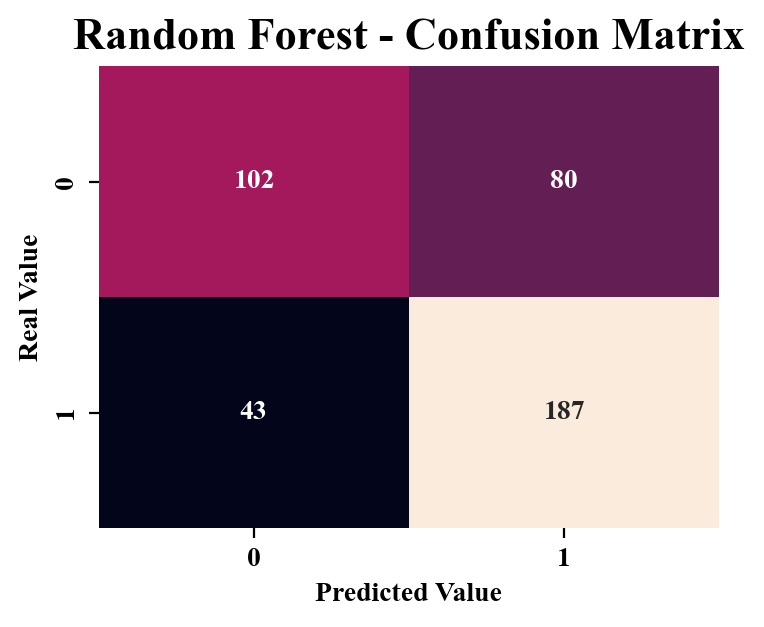

In [53]:
plot_cm(y_test, forest_optimized_test_pred, 'Random Forest')

## 7.4 Gradient Boosting Classifier
- As a fourth model, a **Gradient Boosting Classifier (GBC)** is trained in the meta-labelling pipeline.  
- Setup includes:  
  - **Base estimator:** GradientBoostingClassifier with `random_state=42` for reproducibility.  
  - **Cross-validation:** `TimeSeriesEmbargoCV(cv=5, embargo_size=5)` to prevent leakage between folds.  
  - **Calibration:** Isotonic method applied via `CalibratedClassifierCV` for probability calibration.  
  - **Parallelization:** `n_jobs=1` (due to library constraints on parallelization with GBC).  

- The **training process, threshold optimization, and evaluation** steps are identical to those used in previous models.  

- As with the Random Forest, **learning curves were not estimated** here. Gradient Boosting models are typically **less informative under incremental sample size analysis**, since they focus on sequential error correction and tend to stabilize without clear bias–variance diagnostics from standard learning curves.  

In [54]:
gbc = CalibratedClassifierCV(estimator=GradientBoostingClassifier(random_state=42),
                             cv=TimeSeriesEmbargoCV(cv=5, embargo_size=5),
                             method='isotonic',
                             n_jobs=1)

In [55]:
gbc.fit(x_train_scaled, y_train)

CalibratedClassifierCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5),
                       estimator=GradientBoostingClassifier(random_state=42),
                       method='isotonic', n_jobs=1)

In [56]:
gbc_train_pred = gbc.predict(x_train_scaled)
gbc_test_pred = gbc.predict(x_test_scaled)

gbc_train_prob = gbc.predict_proba(x_train_scaled)[:, 1]
gbc_test_prob = gbc.predict_proba(x_test_scaled)[:, 1]

Best Fb Threshold: 0.5081311232627022


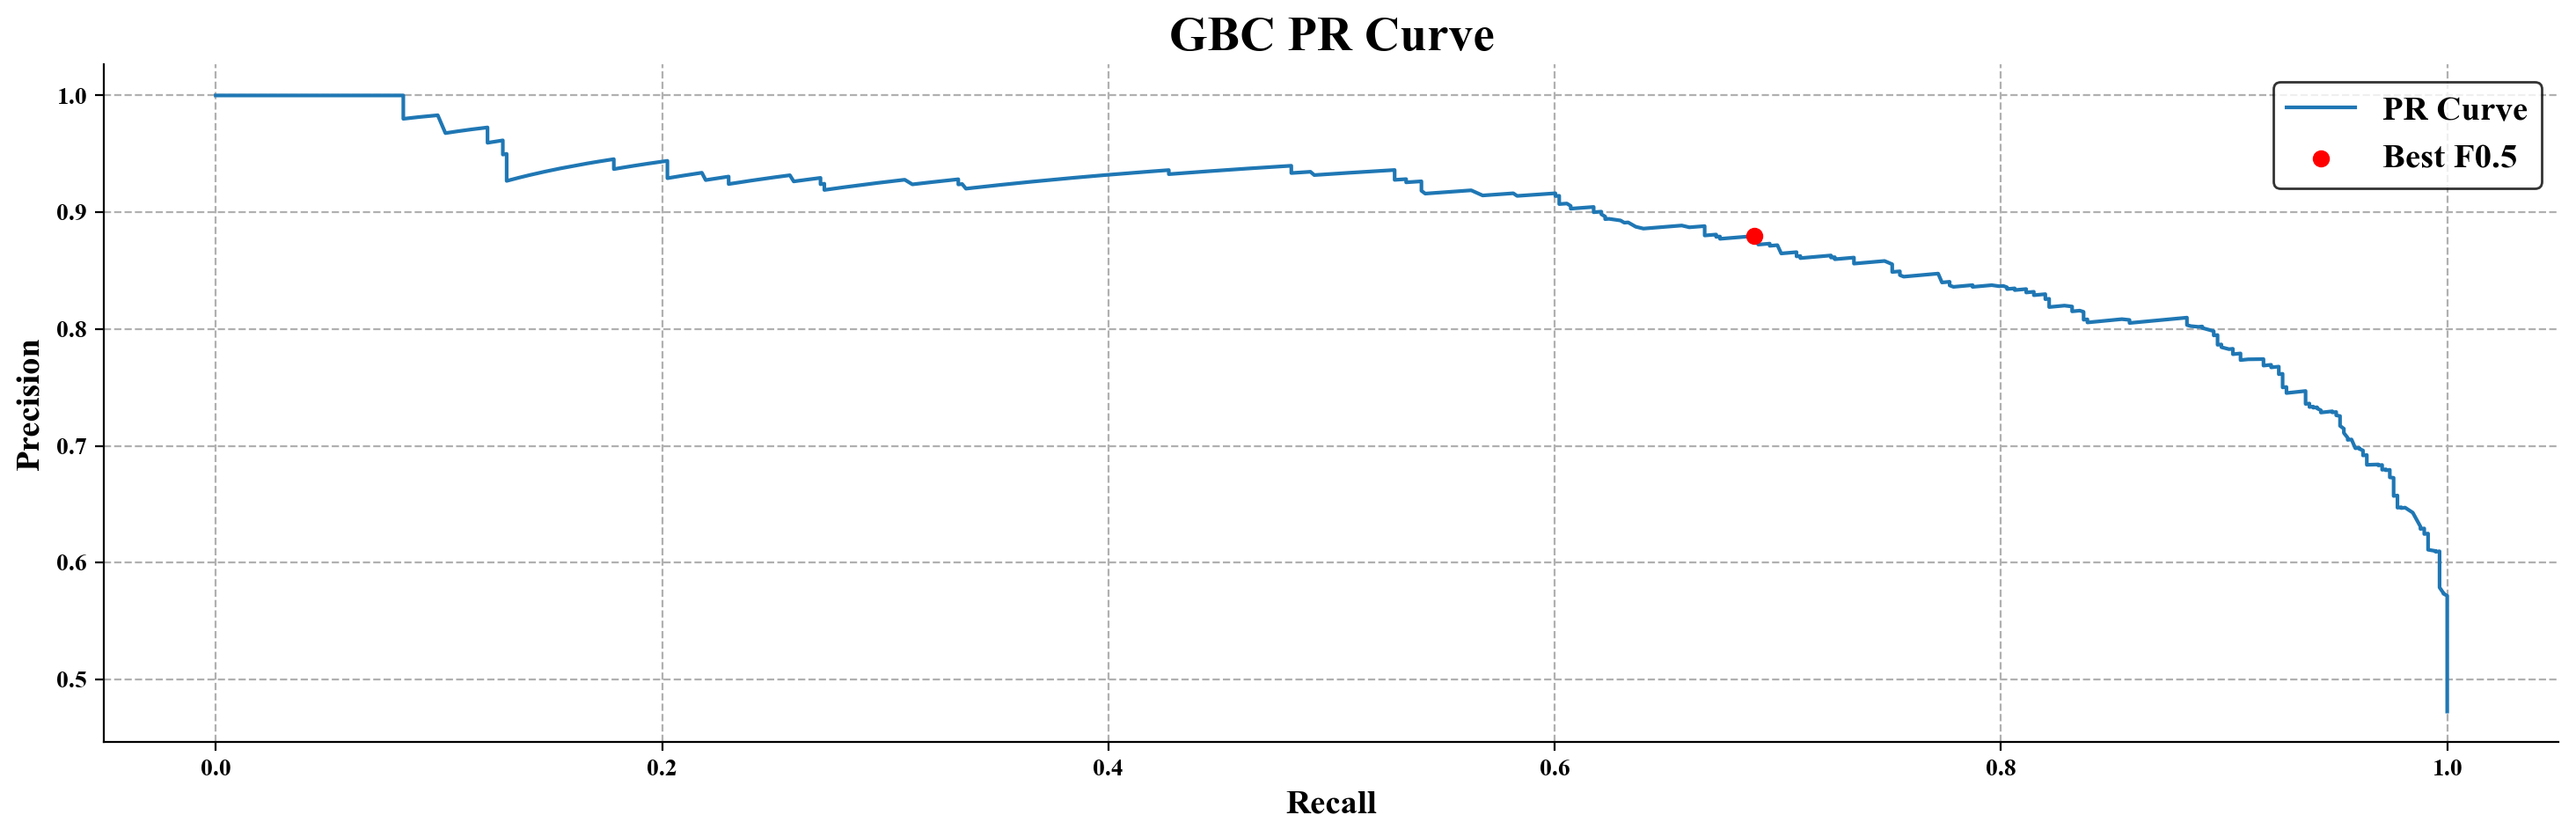

In [57]:
gbc_best_threshold = make_fbeta_curve(y_train, gbc_train_prob, 0.5, 'GBC PR Curve')

In [58]:
gbc_optimized_train_pred = (gbc_train_prob >= gbc_best_threshold).astype(int)
gbc_optimized_test_pred = (gbc_test_prob >= gbc_best_threshold).astype(int)

In [59]:
evaluate_classifier(y_train, gbc_optimized_train_pred)

{'Precision': 0.8796498905908097,
 'Recall': 0.6895368782161235,
 'Accuracy': 0.8087520259319287,
 'f1': 0.7730769230769231,
 'f_beta(0.75)': 0.8002229476869177}

In [60]:
evaluate_classifier(y_test, gbc_optimized_test_pred)

{'Precision': 0.696969696969697,
 'Recall': 0.8,
 'Accuracy': 0.6941747572815534,
 'f1': 0.7449392712550608,
 'f_beta(0.75)': 0.73085478233238}

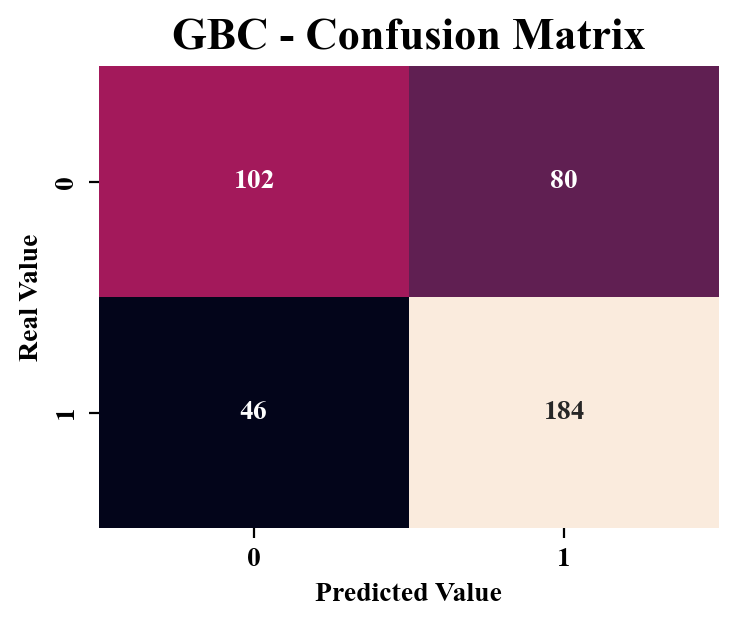

In [61]:
plot_cm(y_test, gbc_optimized_test_pred, 'GBC')

## 7.5 Stacking Ensemble (Random Forest + Gradient Boosting)

- To combine the strengths of the two best-performing models, a **StackingClassifier** was trained using **Random Forest** and **Gradient Boosting** as base learners.  
- Setup includes:  
  - **Base learners:**  
    - Random Forest (200 trees, calibrated with isotonic method, using TimeSeriesEmbargoCV).  
    - Gradient Boosting (calibrated with isotonic method, using TimeSeriesEmbargoCV).  
  - **Final estimator:** LogisticRegressionCV, chosen for its interpretability, stability, and natural ability to handle calibrated probability inputs.  

- Both base models provide **calibrated probability outputs**, ensuring consistent input scaling for the meta-learner.  
- The training, threshold optimization, and evaluation steps follow the same methodology as with the individual models.  

- **Purpose of stacking:**  
  - To leverage the **recall advantage of Random Forest** and the **precision strength of Gradient Boosting**.  
  - Logistic Regression serves as a **meta-model filter**, learning when to trust each base classifier.  

- Overall, the stacking ensemble provided performance close to Gradient Boosting, with slightly improved precision but without surpassing Random Forest in recall.  


In [62]:
stacker = StackingClassifier(
    estimators = 
    [('Random Forest', forest),
    ('Gradient Boosting', gbc)],
    final_estimator=LogisticRegressionCV()
)

In [63]:
stacker.fit(x_train_scaled, y_train)

StackingClassifier(estimators=[('Random Forest',
                                CalibratedClassifierCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5),
                                                       estimator=RandomForestClassifier(n_estimators=200,
                                                                                        random_state=42),
                                                       method='isotonic',
                                                       n_jobs=-1)),
                               ('Gradient Boosting',
                                CalibratedClassifierCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5),
                                                       estimator=GradientBoostingClassifier(random_state=42),
                                                       method='isotonic',
                                                       n_jobs=1))],
                   final_estimator=LogisticRegressionCV())

In [64]:
stacker_train_pred = stacker.predict(x_train_scaled)
stacker_test_pred = stacker.predict(x_test_scaled)

stacker_train_prob = stacker.predict_proba(x_train_scaled)[:, 1]
stacker_test_prob = stacker.predict_proba(x_test_scaled)[:, 1]

Best Fb Threshold: 0.4846636380121226


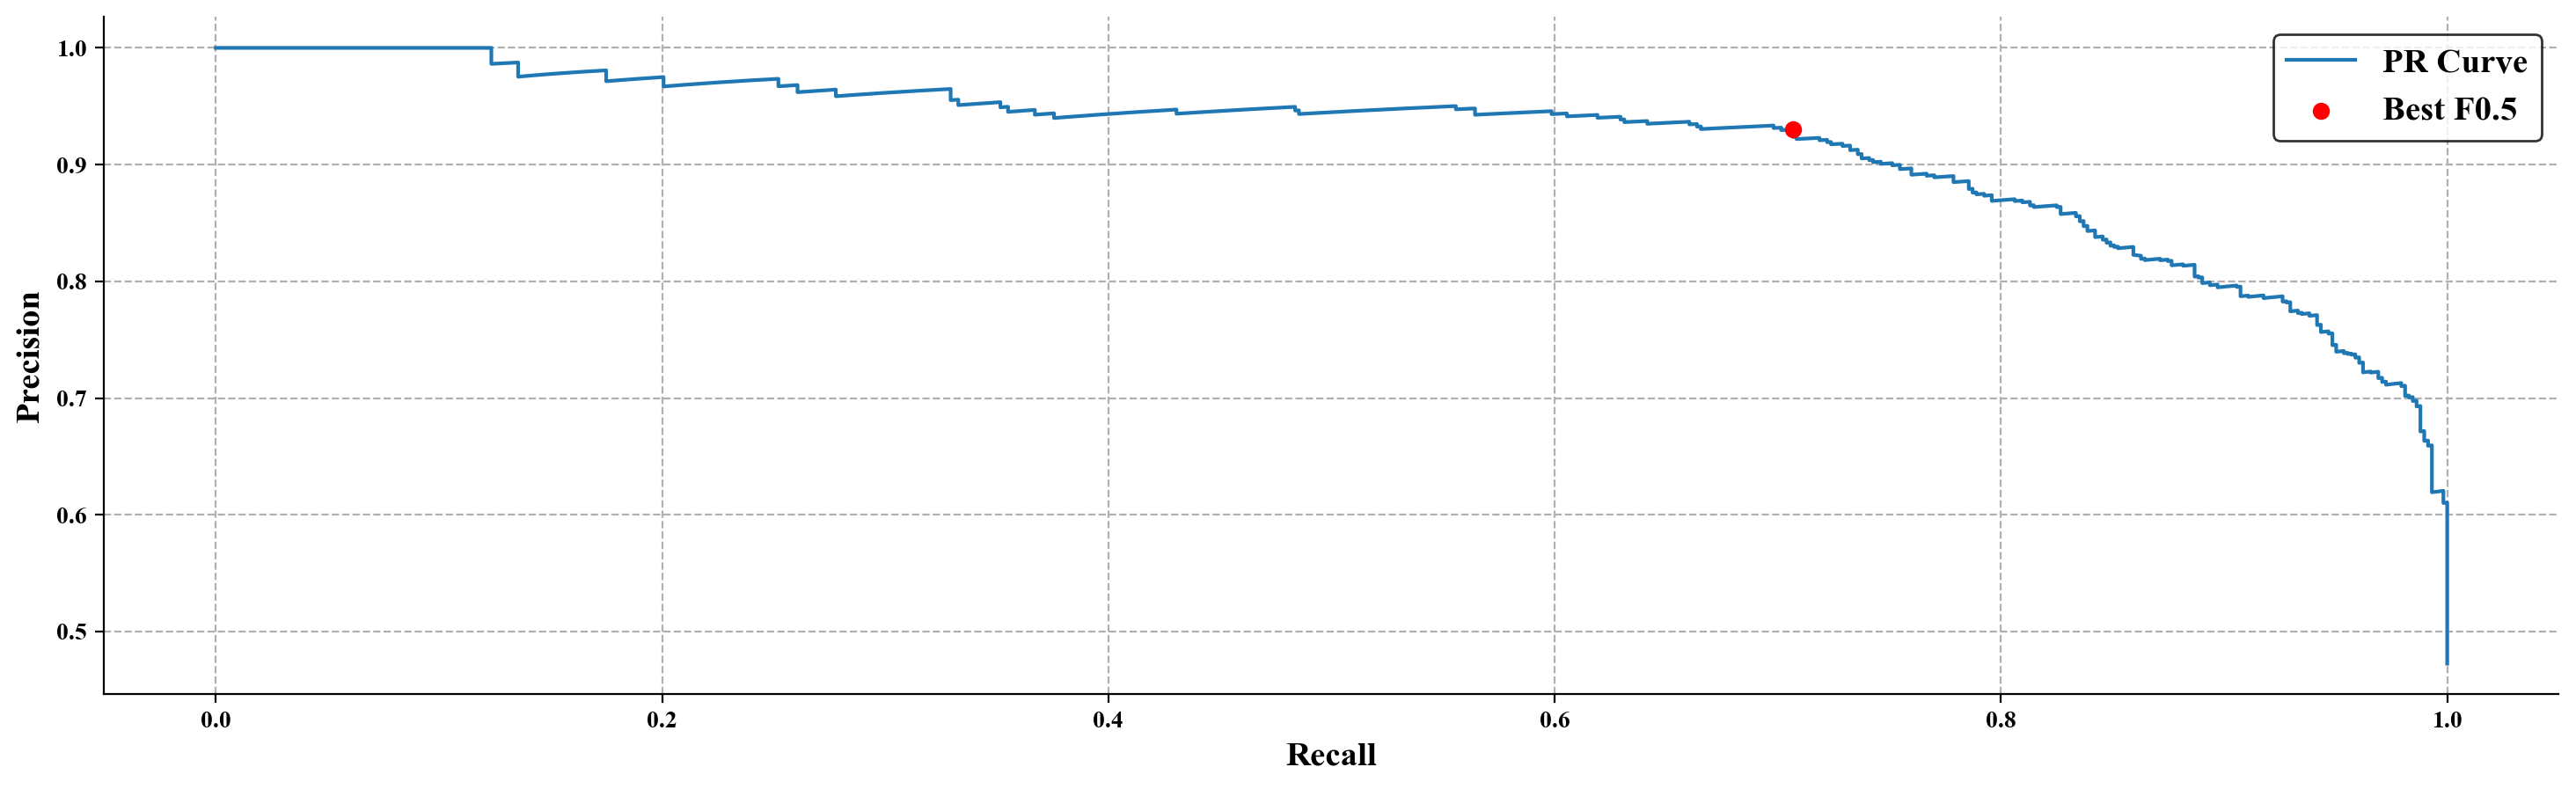

In [65]:
stacker_best_threshold = make_fbeta_curve(y_train, stacker_train_prob)

In [66]:
stacker_optimized_train_pred = (stacker_train_prob >= stacker_best_threshold).astype(int)
stacker_optimized_test_pred = (stacker_test_prob >= stacker_best_threshold).astype(int)

In [67]:
evaluate_classifier(y_train, stacker_optimized_train_pred)

{'Precision': 0.9300225733634312,
 'Recall': 0.7066895368782161,
 'Accuracy': 0.8363047001620746,
 'f1': 0.8031189083820662,
 'f_beta(0.75)': 0.8350222942845561}

In [68]:
evaluate_classifier(y_test, stacker_optimized_test_pred)

{'Precision': 0.7171314741035857,
 'Recall': 0.782608695652174,
 'Accuracy': 0.7063106796116505,
 'f1': 0.7484407484407485,
 'f_beta(0.75)': 0.7394019060138022}

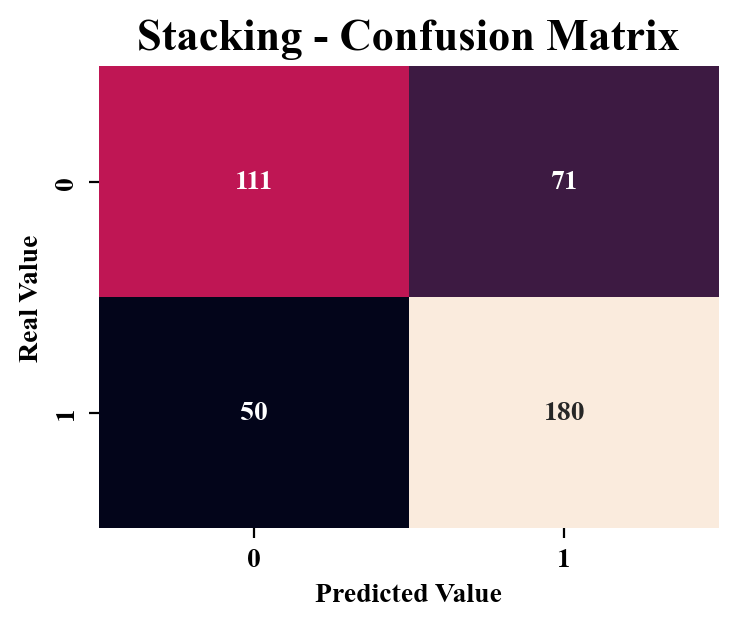

In [69]:
plot_cm(y_test, stacker_optimized_test_pred, 'Stacking')

## 7.5. Model Comparison and Summary

- After training and evaluating five models, the strongest performers were **Random Forest**, **Gradient Boosting**, and their **Stacking ensemble**.  
- Key insights from the evaluation:

- **Random Forest**  
  - Precision: 0.70  
  - Recall: 0.81  
  - Accuracy: 0.70  
  - F$_1$: 0.75  
  - F$_{0.75}$: 0.74  
  - Achieved the **highest recall** and a strong balance overall, making it the most reliable individual model.  

- **Gradient Boosting Classifier (GBC)**  
  - Precision: 0.70  
  - Recall: 0.80  
  - Accuracy: 0.69  
  - F$_1$: 0.74  
  - F$_{0.75}$: 0.73  
  - Similar to Random Forest, but with slightly lower recall and overall performance, leading to more missed positives.  

- **Stacking (RF + GBC with Logistic Regression meta-learner)**  
  - Precision: 0.72  
  - Recall: 0.78  
  - Accuracy: 0.71  
  - F$_1$: 0.75  
  - F$_{0.75}$: 0.74  
  - Delivered performance in between Random Forest and GBC, with slightly higher precision than both, but recall remained below Random Forest.  

---

- **Summary:**  
  - Random Forest achieved the **best recall** and the most balanced performance, confirming its robustness as a standalone model.  
  - Gradient Boosting provided similar results but with slightly weaker recall.  
  - The Stacking ensemble offered **incremental improvements in precision and accuracy**, but did not significantly outperform Random Forest.  

# 8. Backtesting with Meta-Model Integration

- In this stage, the signals from the **Random Forest classifier** are used not only to generate trade directions, but also to **filter and size positions** based on the meta-model’s confidence.  
- The objective is to compare the performance of:  
  - **Raw strategy signals** (unfiltered).  
  - **Meta-model filtered signals** (only signals deemed reliable).  

---

### Position Sizing
- Trade size is dynamically adjusted by the predicted probability from the meta-model:  
  $$
  \text{Size}_t = 100 \cdot \big(1 + \hat{p}_t\big)
  $$
  where $\hat{p}_t$ is the Random Forest predicted probability of signal correctness.  
- This ties **capital allocation** to **model confidence**, giving more weight to high-certainty trades.

---

### Signal Filtering
- The meta-model provides a binary approval label $M_t$:  
  - $M_t = 1$ → signal is trustworthy.  
  - $M_t = 0$ → signal is discarded.  
- Final filtered signals are given by:  
  $$
  F_t = M_t \cdot S_t
  $$
  where $S_t \in \{-1, 0, +1\}$ is the raw trading signal.  

---

### Backtesting Procedure
- Positions are constructed as a **persistent vector**: once entered, the position is held until an exit signal occurs.  
- Entry and exit rules:  
  - **Long entry:** previous position $\neq 1$ and new position $=1$.  
  - **Long exit:** previous position $=1$ and new position $\neq 1$.  
  - **Short entry:** previous position $\neq -1$ and new position $=-1$.  
  - **Short exit:** previous position $=-1$ and new position $\neq -1$.  

---

### Portfolio Simulation
- The backtest is run with **vectorbt**, starting with an initial capital of \$10,000.  
- Inputs:  
  - Aligned price series for the test period.  
  - Filtered signals.  
  - Dynamic trade sizes.  
  - Daily frequency (`freq='1D'`).  

- The portfolio statistics (`pf.stats()`) provide a direct performance comparison between:  
  - The **clean signal strategy** (without meta-model filtering).  
  - The **meta-model enhanced strategy** (with probability-based filtering and position sizing).  

---

- **Outcome:** This approach allows the meta-model not only to **filter unreliable trades**, but also to **scale exposure according to confidence**, potentially improving both risk-adjusted returns and stability of the strategy.

In [70]:
meta_labels = forest_optimized_test_pred.copy()
test_signals = signals[-len(meta_labels):]

# Convert predictions to Series with proper index
meta_labels = pd.Series(meta_labels, index=test_signals.index).astype(int)

In [71]:
len(meta_labels), len(test_signals)

(412, 412)

In [72]:
# Prices only within the test set period
px = prices.loc[test_signals.index]

# Test set signals only
sig = test_signals.astype(int)

# Persistent position vector
positions = sig.replace(0, np.nan).ffill().fillna(0).astype(int)

# Transitions ↦ entries/exits
prev = positions.shift(1).fillna(0).astype(int)
entries_long  = (prev != 1)  & (positions == 1)
exits_long    = (prev == 1)  & (positions != 1)
entries_short = (prev != -1) & (positions == -1)
exits_short   = (prev == -1) & (positions != -1)

# Portfolio limited to the test window
pf_sig = vbt.Portfolio.from_signals(
    close=px,
    entries=entries_long,
    exits=exits_long,
    short_entries=entries_short,
    short_exits=exits_short,
    init_cash=10_000,
    freq='1D'
)

print(pf_sig.stats())

Start                         2024-01-09 00:00:00
End                           2025-08-29 00:00:00
Period                          412 days 00:00:00
Start Value                               10000.0
End Value                            10879.809333
Total Return [%]                         8.798093
Benchmark Return [%]                     8.957531
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        51.419478
Max Drawdown Duration           371 days 00:00:00
Total Trades                                    9
Total Closed Trades                             8
Total Open Trades                               1
Open Trade PnL                        3999.900839
Win Rate [%]                                 37.5
Best Trade [%]                          20.309577
Worst Trade [%]                        -25.302671
Avg Winning Trade [%]                   12.295379
Avg Losing Trade [%]                   -12.917481


In [73]:
# Prices aligned to test period
px = prices.loc[test_signals.index]

# Dynamic trade size based on predicted probabilities
sizes = 100 * ((1 + forest_test_prob))

# Keep only signals approved by the meta-labels
approved = (meta_labels == 1).astype(int)
filtered = (approved * test_signals).astype(int)

# Position vector (persistent position until next change)
positions = filtered.replace(0, np.nan).ffill().fillna(0).astype(int)

# Previous position to detect transitions
prev = positions.shift(1).fillna(0).astype(int)

# Long entries / exits
entries_long  = (prev != 1)  & (positions == 1)
exits_long = (prev == 1) & (positions != 1)

# Short entries/exits
entries_short = (prev != -1) & (positions == -1)
exits_short = (prev == -1) & (positions != -1)

# Portfolio simulation with vectorbt
pf = vbt.Portfolio.from_signals(
    close=px,
    entries=entries_long,
    exits=exits_long,
    short_entries=entries_short,
    short_exits=exits_short,
    init_cash=10_000,
    size=sizes,
    freq='1D'
)

print(pf.stats())

Start                         2024-01-09 00:00:00
End                           2025-08-29 00:00:00
Period                          412 days 00:00:00
Start Value                               10000.0
End Value                            14006.153932
Total Return [%]                        40.061539
Benchmark Return [%]                     8.957531
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        61.606488
Max Drawdown Duration           345 days 00:00:00
Total Trades                                    5
Total Closed Trades                             4
Total Open Trades                               1
Open Trade PnL                        4118.393676
Win Rate [%]                                 50.0
Best Trade [%]                          17.014823
Worst Trade [%]                        -16.821978
Avg Winning Trade [%]                    8.956297
Avg Losing Trade [%]                   -13.633431


## 8.5 Backtest Results – With and Without Meta-Model

To assess the added value of the meta-model, we compare the backtest of the **raw strategy signals** versus the **meta-model filtered strategy**.

---

### Strategy Without Meta-Model
- **Total Return:** +8.8%  
- **Benchmark Return:** +8.95% (strategy underperformed)  
- **Max Drawdown:** -51.4%  
- **Sharpe Ratio:** 0.42  
- **Calmar Ratio:** 0.15  
- **Total Trades:** 9 (Win Rate: 37.5%)  
- **Profit Factor:** 0.54  
- Negative **Expectancy** (-390), showing that on average trades lost money.  
- Conclusion: Strategy was volatile, with deep drawdowns and limited profitability.

---

### Strategy With Meta-Model
- **Total Return:** +40.1%  
- **Benchmark Return:** +8.95% (strategy outperformed benchmark strongly)  
- **Max Drawdown:** -61.6% (higher downside risk, but shorter duration than raw strategy)  
- **Sharpe Ratio:** 0.77  
- **Calmar Ratio:** 0.56  
- **Total Trades:** 5 (Win Rate: 50%)  
- **Profit Factor:** 0.97  
- **Expectancy:** -28 (near breakeven on a per-trade basis, but large winners drove portfolio growth).  
- Conclusion: Meta-model filtering significantly **improved overall returns and risk-adjusted performance**, even with fewer trades. However, higher drawdowns indicate that risk management and position sizing remain critical.

---

### Overall Insight
- The **meta-model enhanced strategy** clearly outperformed the raw signals in terms of **total return and risk-adjusted metrics** (Sharpe, Sortino, Calmar).  
- Although drawdowns increased in magnitude, the improved precision and selective trade filtering enabled higher long-term growth.  
- Future work should focus on **refining position sizing** and **drawdown control**, but results highlight the potential of **meta-labelling as a performance amplifier** in systematic trading.  

## 9. Conclusion

The flagship goal of this project was to demonstrate an improvement in signal quality through the use of a **meta-model**.  
For this purpose, a simple strategy was implemented, based on **Bollinger Bands** with additional light conditions on the moving average and a persistence filter.  

Several machine learning algorithms were trained, among which the **Random Forest** was ultimately selected, showing slightly better performance compared to Gradient Boosting and Stacking.

---

### Key Findings
- The meta-model showed a **significant improvement** in overall strategy performance:  
  - Achieved a return of **+40.1%**, compared to only **+8.8%** for the raw signal – an improvement of **31.3 percentage points**.  
  - Outperformed the benchmark by **31.1 percentage points**, while the raw signal failed to beat the benchmark.  
  - **Sharpe ratio** improved from 0.42 to 0.77 (+0.35).  
  - **Profit factor** increased from 0.54 to 0.97 (+0.43).  
  - **Win rate** improved from 37.5% to 50%.  

- However, the meta-model strategy also showed **higher risk**:  
  - Maximum drawdown increased from **51.4%** to **61.6%** (+10.2 percentage points), an unrealistically high level for practical deployment.  
  - The average loss per losing trade was slightly higher compared to the base strategy, but worst trade was significantly lower.
  - These results highlight that **risk management requires further refinement**, which was beyond the scope of this experiment.  

- Overall, the experiment achieved its goal: the meta-model demonstrated a **clear improvement in profitability and risk-adjusted performance**, albeit with elevated drawdown risk.

---

### Limitations
1. The experiment was conducted on a **single stock** with **daily data**. Different securities or time frequencies may yield different results and require specific adjustments.  
2. The models, especially the advanced ones (Random Forest, Gradient Boosting), were **not hyperparameter-tuned**. Nevertheless, they performed sufficiently well for the purposes of this study.  
3. The base strategy (the raw signal) was intentionally **simple and well-known**, designed for demonstration rather than production-level trading. More sophisticated strategies may behave differently.  

---

### Future Directions
1. Training the models on **clusters of assets** with similar statistical behavior could enable broader generalization without retraining for each individual security.  
2. Extending the experiment to **lower-frequency data** and testing alternative bar constructions such as **Imbalance Volume Bars** or **Dollar Bars**.  